In [1]:
import cv2
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import matplotlib.image as mpimg
from scipy import ndimage

In [2]:
# vedio to image
vidcap = cv2.VideoCapture('data/project/robot_parcours_1.avi')
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrame,frame = vidcap.read()
#     if hasFrames:
#         cv2.imwrite("data/project/image"+str(count)+".png", image)     # Uncomment to save frame as png file(lossless)
    return hasFrame,frame
sec = 0
frameRate = 2 #//Frame rate = 2 FPS, it will capture image in each 0.5 second
count=0
hasFrame, frames = getFrame(sec)
frames = np.expand_dims(frames[:,:,::-1],0) # Indexing to convert from BGR to RGB because matplotlib decides to do it backwards

while hasFrame:
    if count > 0:
        frames = np.concatenate((frames,np.expand_dims(frame[:,:,::-1],0)),0)
    count = count + 1
    sec = round(count/frameRate, 2)
    hasFrame, frame = getFrame(sec)
    

In [3]:
# Segmentation red arrow
def arrowDetect(frame_input):
    frame = frame_input.copy()
    framehsv = cv2.cvtColor(~frame, cv2.COLOR_RGB2HSV) # invert image so that red becomes cyan in HSV
    lower = np.array([90-10,80,50])
    upper = np.array([90+10,255,255])

    mask = cv2.inRange(framehsv, lower, upper)
    arrow = cv2.bitwise_and(frame,frame, mask= mask)
    # Bounding box
    contours, hierarchy = cv2.findContours(arrow[:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    c = contours[0] # longest contour
    x, y, w, h = cv2.boundingRect(c)
    cv2.circle(frame, (x+w//2,y+h//2), 5, (0,255,0),-1)
    return frame, (x, y, w, h) # frame with center point shown and the four bounding box parameters

In [4]:
def trackArrow(frames_input):
    frames_output = np.zeros_like(frames_input)
    centers = np.array([]).reshape([0,2])
    for i, frame_input in enumerate(frames_input):
        frame_output, (x, y, w, h) = arrowDetect(frame_input)
        center = np.expand_dims(np.array([x+w//2, y+h//2]),0)       
        centers = np.concatenate([centers, center], 0)
        cv2.polylines(frame_output, np.int32([centers]), False, (0,255,0), thickness = 3) 
        frames_output[i] = frame_output
    return frames_output

In [5]:
frames_output = trackArrow(frames)

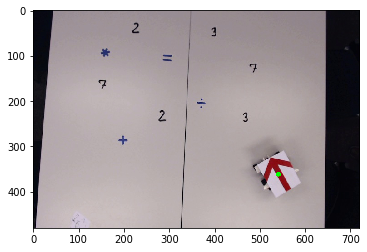

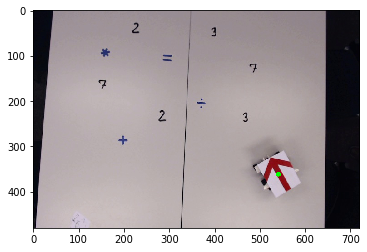

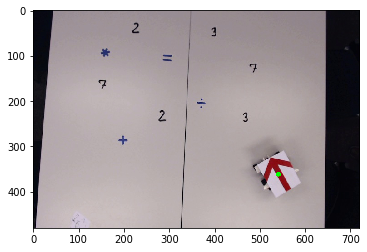

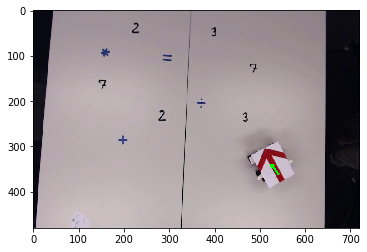

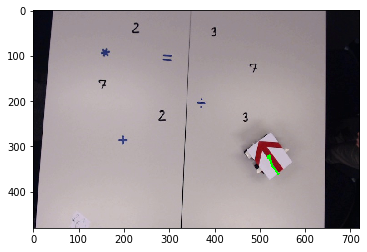

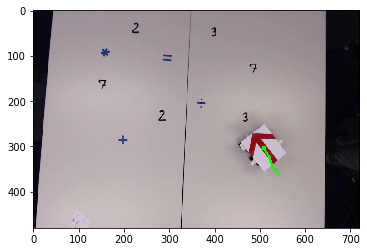

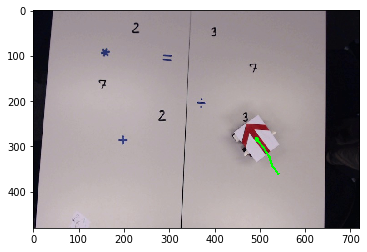

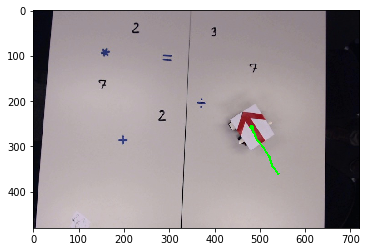

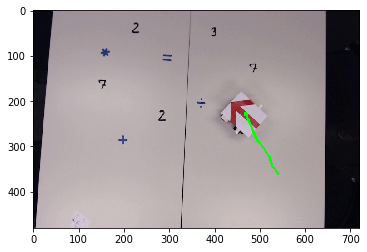

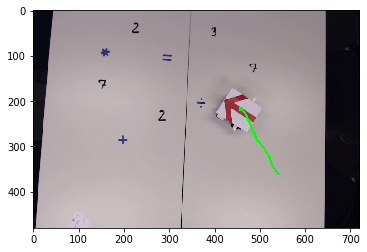

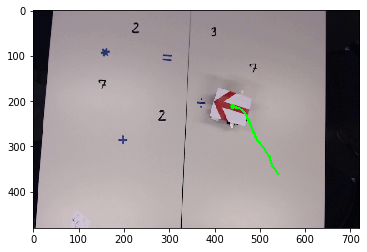

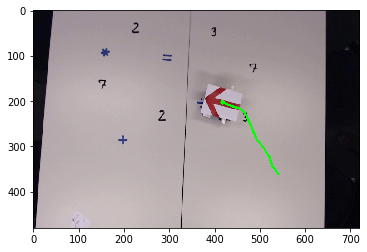

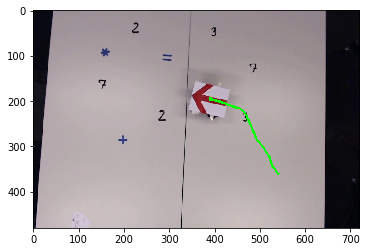

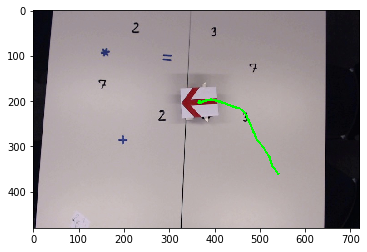

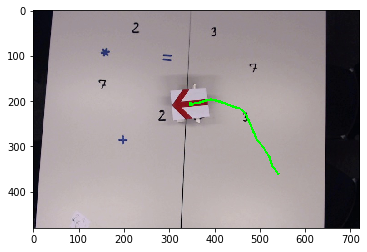

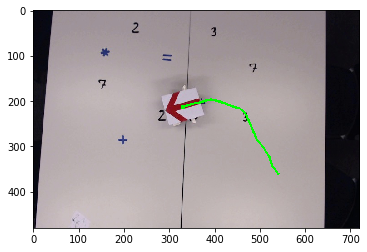

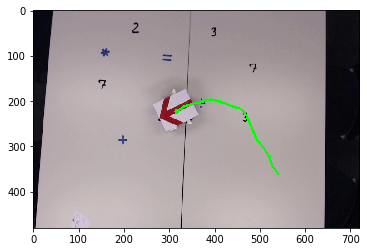

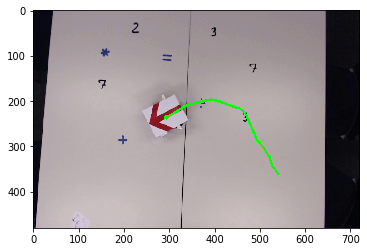

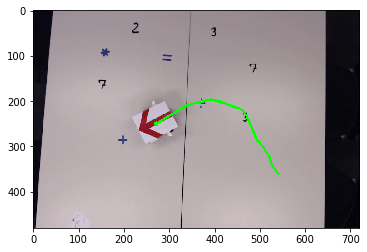

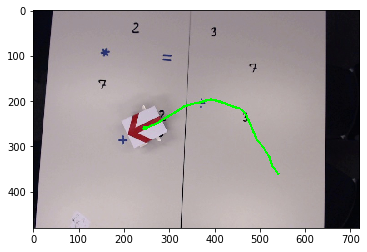

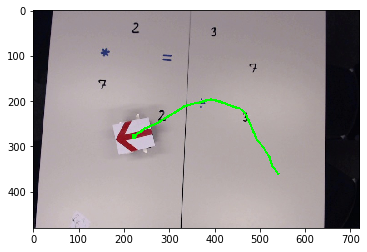

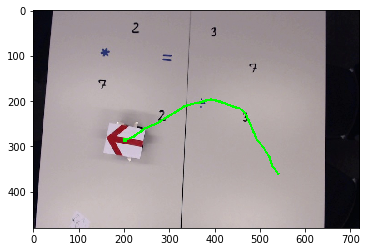

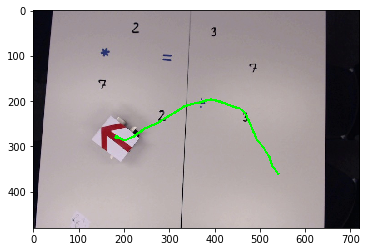

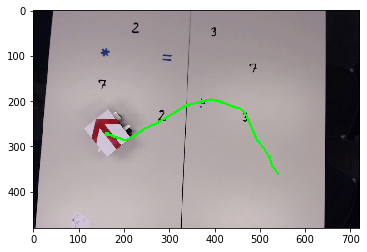

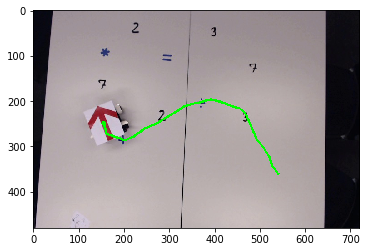

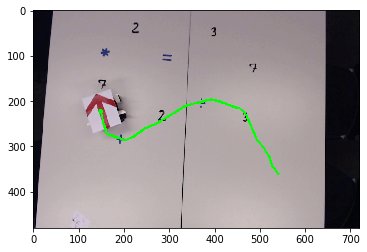

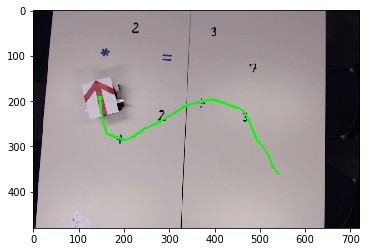

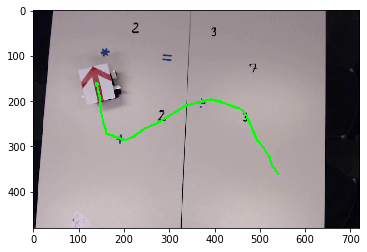

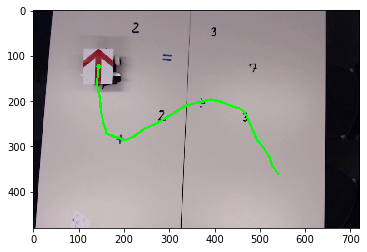

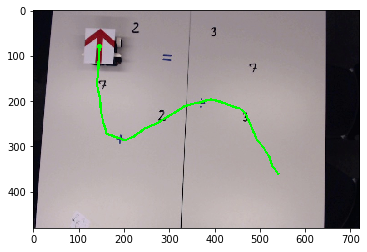

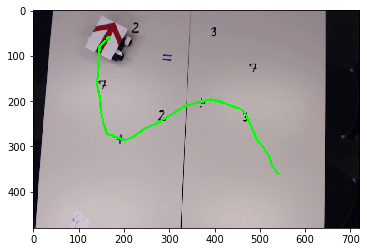

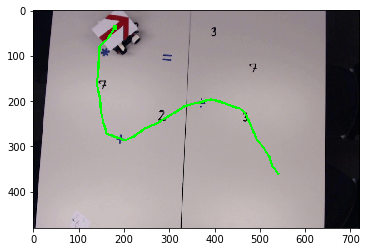

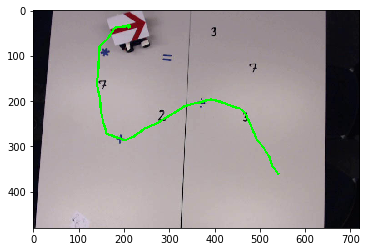

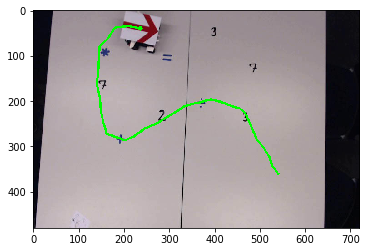

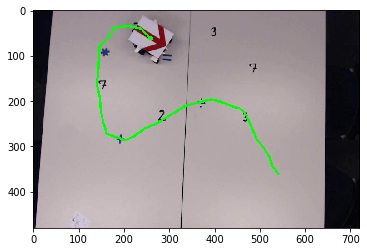

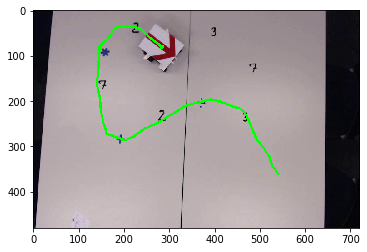

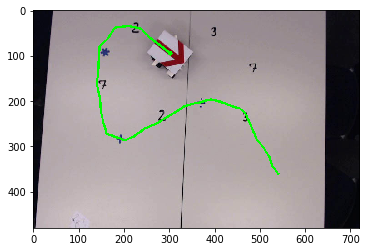

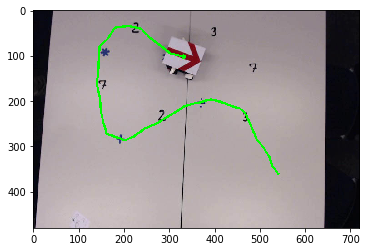

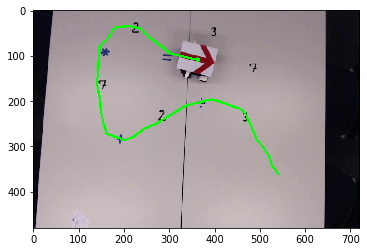

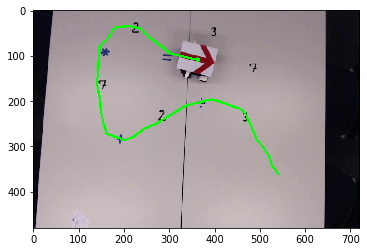

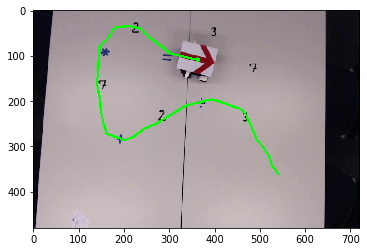

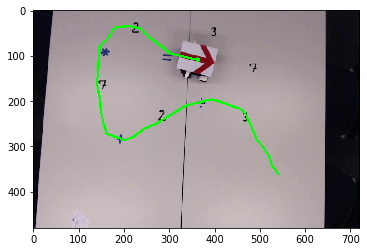

In [6]:
for frame_output in frames_output:
    plt.imshow(frame_output)
    plt.show()

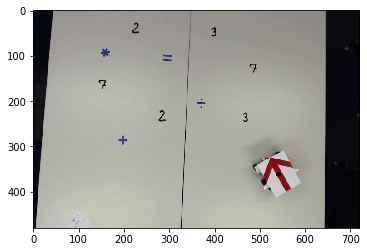

In [7]:
def whiteBalance(frame, x, y, w, h):
# White balance with white area on the robot as reference 
# (probably only needed for first frame, or can use the same ref white values for all frames)
    frameGrid = np.meshgrid(np.arange(frame.shape[1]),np.arange(frame.shape[0]))
    mask = (frameGrid[1]< y+h) & (frameGrid[1]> y) & (frameGrid[0]<x+w) & (frameGrid[0]>x)
    mask3 = np.stack([mask]*3, axis=2)
    maskedArrowBoxGray = cv2.cvtColor(frame*mask3, cv2.COLOR_RGB2GRAY)
    mask_white = cv2.threshold(maskedArrowBoxGray, maskedArrowBoxGray.max()*0.9, maskedArrowBoxGray.max(), cv2.THRESH_BINARY)[1]
    mask_white[mask_white>0] = 1
    mask_white3 = np.stack([mask_white]*3, axis=2)
    refWhite = mask_white3*frame
#     plt.imshow(refWhite)
    meanRefWhite = (np.mean(refWhite[refWhite>0].reshape([-1,3]),0)) # mean white value for reference
    lum = np.sum(meanRefWhite)/3
    framewb = frame.copy()
    framewb[:,:,0] = framewb[:,:,0] * lum / meanRefWhite[0]
    framewb[:,:,1] = framewb[:,:,1] * lum / meanRefWhite[1]
    framewb[:,:,2] = framewb[:,:,2] * lum / meanRefWhite[2]
    return framewb, meanRefWhite

frame, (x, y, w, h) = arrowDetect(frames[0])
framewb, meanRefWhite = whiteBalance(frame, x, y, w, h)
plt.imshow(framewb)

### Notes: 
Deadline: Thursday(5/7)

0. pretrain classifiers with data augmentation: digits from MNIST, operators (together (in frame0) or separate (while moving)?)
    start with diffferent colors for digit/operator, then all black for bonus (CV)
1. 1st frame: segmentation of the digits, operators --> feed segmentation results to classifiers --> classification (WJ)
    color or no color
2. Arrow(robot) tracking: subtraction(?) color segmentation(?) center to center motion between frames (MS)

3. Detect covered digit/operator: 0-8 for digits ("9" as "6"), "+, -, *, division, =" 
4. Output videso with robot tracking and equation formed until "="


In [8]:
# output video

frame_height, frame_width, _ = frame.shape

out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc(*'XVID'),frameRate , (frame_width,frame_height))

for frame_output in frames_output:
    out.write(frame_output[:,:,::-1])


out.release()


## 1. Predictor to recognize operators and digits (NB: "9" is not present).
Object recognition to see where they are.
MNIST Digits classifier to recognise digits. Make classifier for operators.
Use first frame to actually recognize the values inside on from this just overlap position of robot.

Old idea: From the position of "robot" (center point) see what is below him: null, digit, operator. These will return as a frame (e.g., 3, 3, 3, 6, 3) => we can therefore detect by majority that the robot is on the 3. --> more inefficient.

In [9]:
frame, (x, y, w, h) = arrowDetect(frames[0])
mainframe, meanRefWhite = whiteBalance(frame, x, y, w, h)

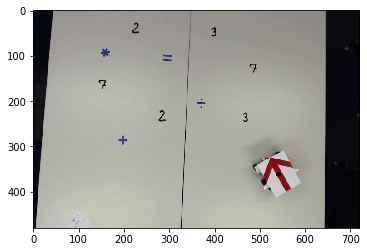

In [10]:
plt.imshow(mainframe)

## Localizate digits/operators
Ideas:
- image morphological operators (e.g. erosion)
- DL (e.g. unsupervised feature detectors)

### Segmentation with area thresholding

18


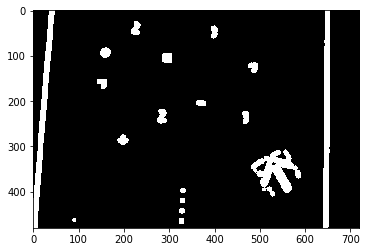

In [32]:
# Morphological operations to make objects of interest more similar to each other while different from other unwanted objects

img = cv2.cvtColor(frames[0], cv2.COLOR_RGB2GRAY)
img = cv2.GaussianBlur(img,(5,5),0)


mask1 = (1-cv2.adaptiveThreshold(img,1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,3))
mask = ndimage.median_filter(mask1,size = 3)

kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))

mask = ndimage.median_filter(mask,size = 7)
mask = ndimage.binary_dilation(mask, structure = kernel1)

# label features
labeled_array, num_features = ndimage.label(mask)
print(num_features)


plt.imshow((mask),cmap = 'gray')
plt.show()

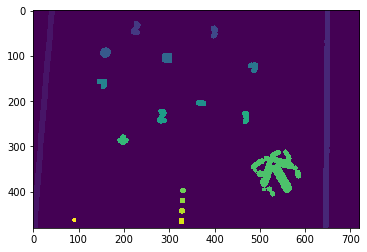

In [33]:
# labeled mask
plt.imshow(labeled_array)

In [34]:
# function to calculate center coordinates of object with given label
def center(labeled_array, xrange, yrange, c, label):
    # find center of objects with given label
    yy, xx = np.meshgrid(yrange,xrange)
    select = labeled_array == label
    center = np.mean([xx[select],yy[select]],1)
    return center


In [35]:
import skimage

# range of image
xrange = np.arange(mask.shape[0])
yrange = np.arange(mask.shape[1])
# center of image
c = [mask.shape[0]//2, mask.shape[1]//2]


area_list = np.zeros([num_features+1,1])
size = np.zeros([num_features+1,2])
object_id = []
object_center = []
contour_list = []

    

# calculate areas and centers, apply threshold on area to select objects of interest
for i in range(num_features+1):
    area = np.sum(labeled_array == i)
    area_list[i] = area

    if (area >= 200) & (area <= 700): # thershold by area to get objects
        object_id.append(i)
        object_center.append(center(labeled_array, xrange, yrange, c, i))

    # get contours
    temp = np.zeros_like(labeled_array)
    temp[labeled_array == i] = 1
    contours = skimage.measure.find_contours(temp,0.8)
    contour = sorted(contours, key=lambda x: len(x))[-1] # get longest contour
    contour_list.append(len(contour))
    
print(sorted(contour_list)) # check contour length

print(sorted(area_list)) # observe that objects of interest have areas that are one order of magnitude different from others'

[37, 49, 51, 51, 55, 75, 95, 95, 97, 99, 99, 101, 103, 121, 127, 490, 518, 815, 815]
[array([57.]), array([120.]), array([132.]), array([132.]), array([156.]), array([258.]), array([355.]), array([357.]), array([381.]), array([395.]), array([396.]), array([439.]), array([453.]), array([481.]), array([520.]), array([5068.]), array([6034.]), array([6121.]), array([323745.])]


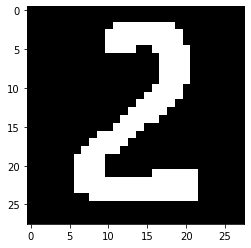

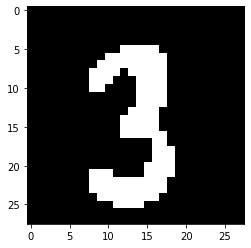

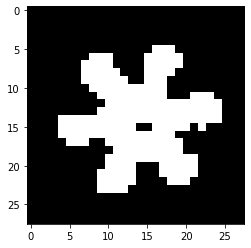

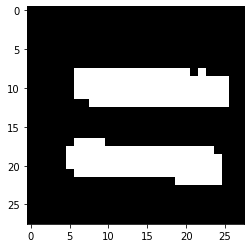

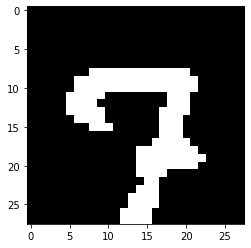

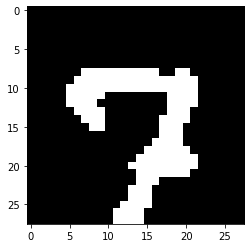

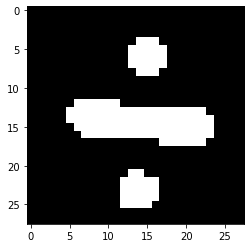

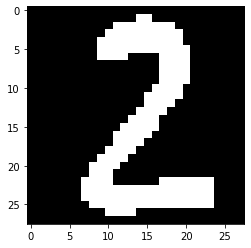

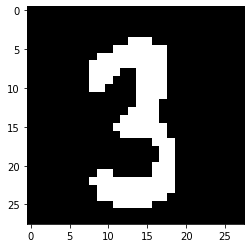

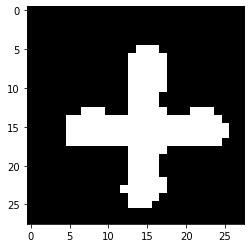

In [36]:
# crop objects with calcualted centers and bounding box size of the arrow on robot
h =28
w =28
objects = np.zeros([len(object_center),h//2 + h//2, w//2+w//2])
mask = (1-cv2.adaptiveThreshold(img,1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,3))

for i, c in enumerate(object_center):
    y,x = c
    objects[i,:] = mask[int(y-h//2):int(y+h//2), int(x-w//2):int(x+w//2)]

# plot images to check
for im in objects:
    plt.imshow(im, cmap = 'gray')
    plt.show()

223


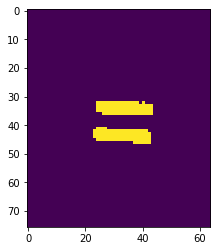

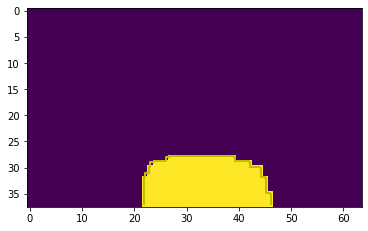

In [16]:
import skimage  #40-100 contour??
test = objects[3]
plt.imshow(test)
test2 = test[:38,:]
test2 = ndimage.median_filter(test2,size = 7)
test2 = ndimage.binary_dilation(test2, structure = kernel1)
contours = skimage.measure.find_contours(test2,0.8)

contour = sorted(contours, key=lambda x: len(x))[-1]

fig, ax = plt.subplots()
ax.imshow(test2, cmap='gray')
ax.step(contour.T[1], contour.T[0], linewidth=2, c='y')


plt.imshow(test2)
print(test2.sum())


In [17]:
# read image from file like this
test = mpimg.imread("data/project/minus.png")
test = 1-cv2.cvtColor(test, cv2.COLOR_RGB2GRAY).astype(np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(129,129))
test = ndimage.median_filter(test,size = 5)
test = ndimage.binary_closing(test, structure = kernel)
plt.imshow(test)


FileNotFoundError: [Errno 2] No such file or directory: 'data/project/minus.png'

In [18]:
img = cv2.imread('original_operators.png')

In [19]:
plus = img[:,0:310]
equal = img[:,340:650]
minus = img[:,710:1020]
devide = img[:,1080:1390]
multiply = img[:,1440:1750]

In [20]:
# importing all the required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import matplotlib.pyplot as plt
import os 

In [21]:
def operators_augmentation(image, operator):
    cnt = -1 
    image = image
    for rot in [0, 30, 45, 90, 135]:
        rotated = rotate(image, angle=rot, mode = 'constant',cval = 1)
        for sig in np.arange(0.1,0.3,0.02):
            noisyRandom = random_noise(rotated,var=sigma**2)
            for sig in np.arange(5, 25):
                cnt+=1
                print(cnt)
                blurred = gaussian(noisyRandom,sigma=sig, multichannel=False)
                io.imsave(os.path.join('operators/'+ operator +'/'+ operator+str(cnt)+".png" ), blurred)
#operators_augmentation(multiply, "multiply")
# operators_augmentation(minus, "minus")
# operators_augmentation(equal, "equal")
# operators_augmentation(devide, "devide")

### Classification

In [22]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import os
from sklearn import naive_bayes

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)
def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [23]:
image_shape = (28, 28)
train_set_size = 60000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')


train_images = extract_data(train_images_path, image_shape, train_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)

In [26]:
# set the 784(28 *28)-dimensional input 
train_size = train_images.shape[0]
X_train = np.reshape(train_images, [train_size, 28*28])
y_train = train_labels

In [27]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=100)

In [28]:
# print network info
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=100, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

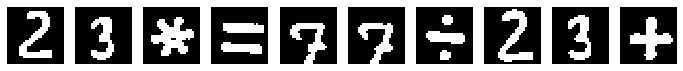

In [37]:
# predict the test set
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im in zip(axes, objects):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

In [38]:
preds = clf.predict(np.reshape(objects*255, [objects.shape[0], 28*28]))
print(preds)

[2 3 8 5 7 7 6 2 3 4]


### Identify/Recognize them (CV)

In [20]:
%load_ext autoreload

%autoreload 2
from classifier import CNNModel, DataGenerator
from utils import remove_9, replicate, preprocessing_mnist_data, normalize, preprocessing_our_data

Using TensorFlow backend.


## Load dataset MNIST
Reference: https://medium.com/@mjbhobe/mnist-digits-classification-with-keras-ed6c2374bd0e

In [21]:
from keras.datasets.mnist import load_data

# load the data - it returns 2 tuples of digits & labels - one for
# the train set & the other for the test set
(train_digits, train_labels), (test_digits, test_labels) = load_data()

test_digits, test_labels = remove_9(test_digits, test_labels)
train_digits, train_labels = remove_9(train_digits, train_labels)

train_data, train_labels_cat, test_data, test_labels_cat = preprocessing_mnist_data(train_digits, train_labels, test_digits, test_labels)
train_data.shape, train_labels_cat.shape, test_data.shape, test_labels_cat.shape

((54051, 70, 54, 1), (54051, 14), (8991, 76, 60, 1), (8991, 14))

In [29]:
to_recognize_digits_operators = preprocessing_our_data(objects)
to_recognize_digits_operators.shape

(10, 76, 64)

4


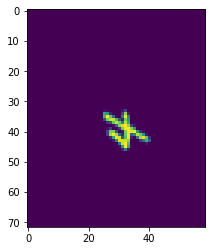

(0.10109356, 0.013925715)

In [23]:
## Example on how to test DataGenerator
g = DataGenerator(train_data[:200], train_labels[:200])
g.image_gen.on_epoch_end()
sample_x, sample_y = g[0]
sample_x.shape, sample_y.shape

im = sample_x[0, :, :, 0]
label = sample_y[0]
print(label)

plt.imshow(im)
plt.show()
im.std(), im.mean()

## Create model for classify digits and operators

In [ ]:
x_train = train_data
y_train = train_labels_cat
print(x_train.shape, y_train.shape)

model = CNNModel(verbose=False)
model.fit(x=x_train, y=y_train, epochs=50, batch_size=64)

## Validation with test

In [ ]:
test_loss, test_accuracy = model.model.evaluate(test_data, test_labels_cat, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))
model.save()

In [ ]:
# check model was saved correctly and load it
new_model = CNNModel(verbose=False)
new_model.load()
test_loss, test_accuracy = new_model.model.evaluate(test_data, test_labels_cat, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

## Make a prediction on our data


In [26]:
# Reshape our dataset adding a dimension
predictions = model.model.predict(np.expand_dims(to_recognize_digits_operators, axis=-1))
preds = np.argmax(predictions, axis=1)
print(preds)
print(predictions[9])

[13 13 13 13 13 13 13 13 13 13]
[0.07140989 0.06911285 0.07461753 0.07254306 0.06705869 0.06983371
 0.07496868 0.07185746 0.07302185 0.07247428 0.0701223  0.06847766
 0.06867655 0.07582539]


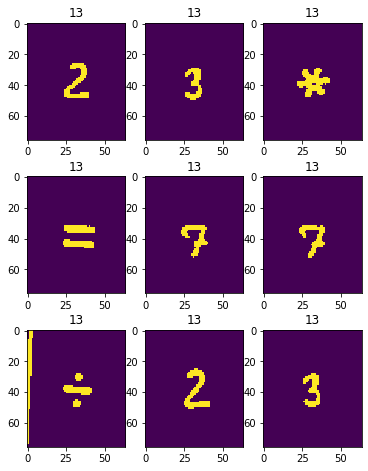

In [30]:
# _, axes = plt.subplots(6, 7)
ax = []

images_and_predictions = list(zip(to_recognize_digits_operators, preds))
# count = 0;
# idx = 0;
columns = len(to_recognize_digits_operators) // 3
rows = 3
figsize = [6, 8]     # figure size, inches

fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=figsize)
for i, (axi, (image, prediction)) in enumerate(zip(ax.flat, images_and_predictions)):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    axi.imshow(image) # cmap=plt.cm.gray_r, interpolation='nearest'
    # get indices of row/column
    rowid = i // columns
    colid = i % columns
    # write row/col indices as axes' title for identification
    axi.set_title('%i' % prediction)

(0.00069945527, 0.00012899899)

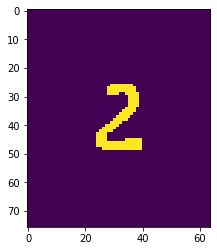

In [31]:
plt.imshow(to_recognize_digits_operators[0])
to_recognize_digits_operators[0].std(), to_recognize_digits_operators[0].mean()